In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [3]:
dataset='../input/utkface-new/UTKFace/'

In [4]:
# labels - age
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(dataset)):
    image_path = os.path.join(dataset, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert dataset into dataframe
df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.head()

,image,age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17


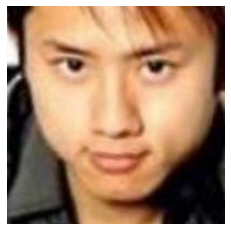

In [6]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

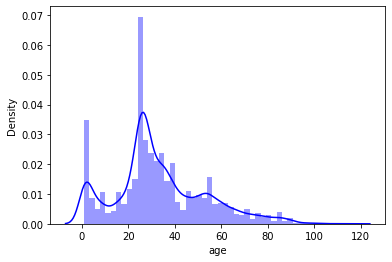

In [7]:
sns.distplot(df['age'],color='b')

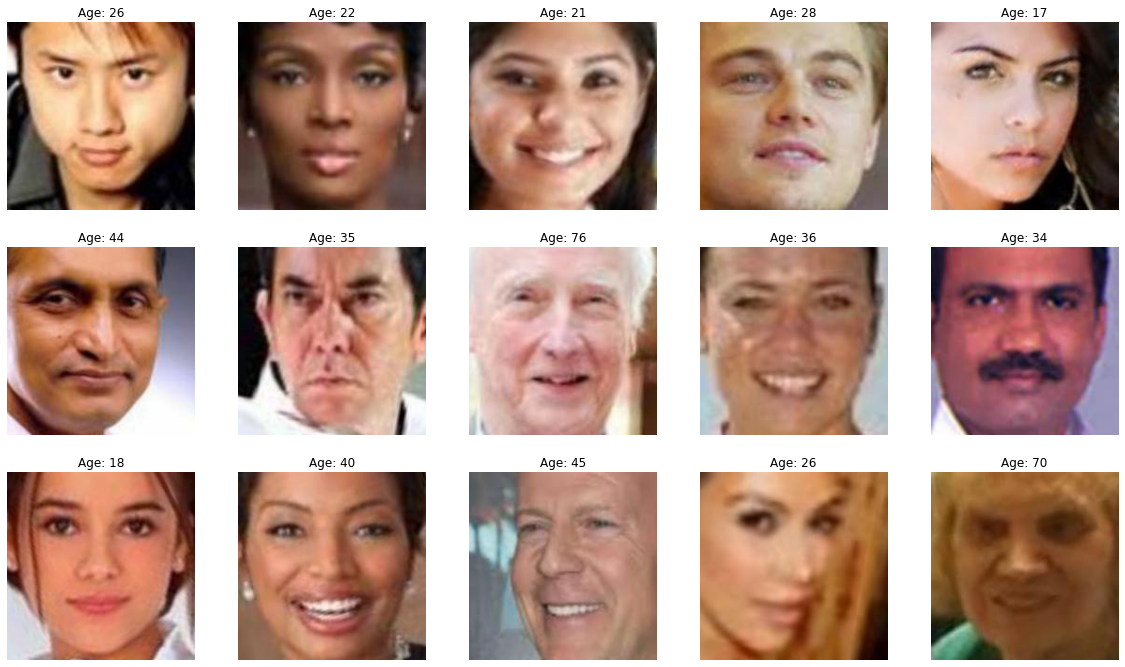

In [8]:
# display images
plt.figure(figsize=(20, 20))
files = df.iloc[0:15]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

In [9]:
#feature extraction
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [10]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
X.shape

(23708, 128, 128, 1)

In [12]:
# normalize the images
X = X/255.0

In [13]:
y_age = np.array(df['age'])

In [14]:
y_age

array([26, 22, 21, ...,  2, 65, 66])

In [15]:
input_shape = (128, 128, 1)

In [16]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)

output_1 = Dense(1, activation='relu', name='age_out') (dropout_1)

model = Model(inputs=inputs, outputs=output_1)

model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

2022-07-21 09:39:36.813623: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


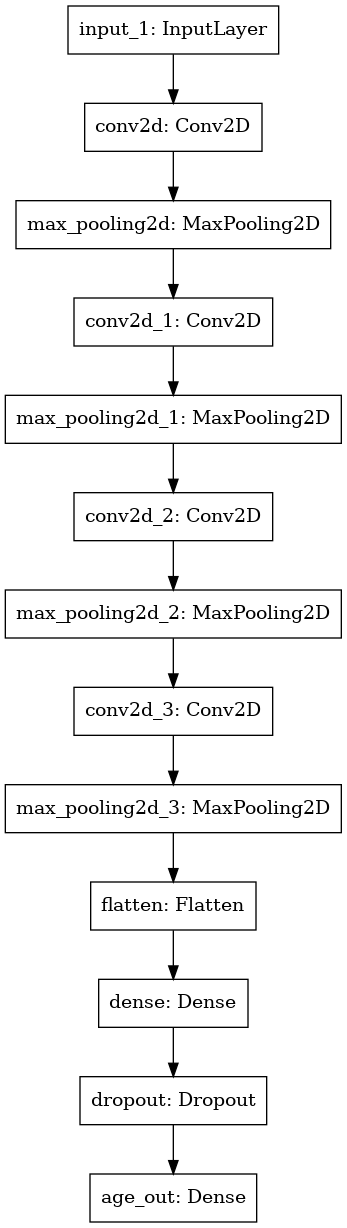

In [17]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
# train model
history = model.fit(x=X, y=y_age, batch_size=64,epochs=30, validation_split=0.3)

Epoch 1/30
260/260 [==============================] - 218s 840ms/step - loss: -493.0131 - accuracy: 0.0492 - val_loss: -491.6481 - val_accuracy: 0.0432
Epoch 2/30
260/260 [==============================] - 218s 839ms/step - loss: -493.0131 - accuracy: 0.0492 - val_loss: -491.6481 - val_accuracy: 0.0432
Epoch 3/30
260/260 [==============================] - ETA: 0s - loss: -493.0131 - accuracy: 0.0492

KeyboardInterrupt: 

In [ ]:
# plot results for age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [ ]:
image_index = 100
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred)
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');